# NMF vs. ICA for examining water structure perturbations

The purpose of this document is to investigate the relative merits of non-negative matrix factorization as proposed by Lawton and Sylvestre in constrast to novel methods of independent component analysis.

We will begin by analyzing NMF outputs, and investigate how noise affects our results. We will follow up by using real data, and attempt to determine if the emerging perturbations of water structure have any basis in fact.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import analytics
import db_helpers as dbh
import sqlite3

In [2]:
path = '/media/deshthedesher/Data/science/raman/benzet/benzet5.db'
cnx = sqlite3.connect(path)
master = pd.read_sql("SELECT * FROM Master WHERE noise IS NOT NULL", con=cnx)
filemaster = pd.read_sql("SELECT * FROM FileMaster", con=cnx)

sns.set_style("ticks")
colors = sns.xkcd_palette(['pumpkin', 'dark blue', 'teal', 'crimson', 'dusty purple', 'evergreen'])
sns.set_palette(colors)

To begin with, we will take the measured raman spectra of pure water and pure phenylethyl alcohol, which I will hereafter simply refer to as 'the hydrocarbon'.

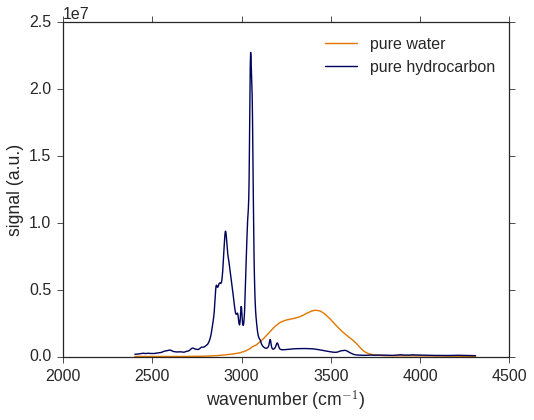

In [72]:
rawwater = pd.read_sql(
    'SELECT * FROM RawData WHERE set_id=3 AND filenumber=1', con=cnx
)

rawcarbon = pd.read_sql(
    'SELECT * FROM RawData WHERE set_id=3 AND filenumber=4', con=cnx
)
trimmer_mask = rawwater['wavenumber'] > 2400
water = rawwater[trimmer_mask]
carbon = rawcarbon[trimmer_mask]

def mpl_spectrum():
    sns.set_context('paper', font_scale=2.0)
    plt.figure(figsize=(8, 6))
    plt.xlabel(r'wavenumber (cm$^{-1}$)')
    plt.ylabel(r'signal (a.u.)')

mpl_spectrum()
plt.plot(water['wavenumber'], water['signal'], label='pure water')
plt.plot(carbon['wavenumber'], carbon['signal'], label='pure hydrocarbon')

plt.legend()
plt.show()

We will suppose that, rather than having these two spectra, we have only the water spectrum, and additionally we have spectra containing trace amounts of hydrocarbon. Our goal is to separate the hydrocarbon spectrum from the water spectrum, without actually knowing the hydrocarbon spectrum. In practice, we want to do this to find whether the hydrocarbon data is associated with any perturbation of the water structure. In order to do this, we would like to first confirm the use of the blind signal separation technique to separate two components which cannot have any perturbations. 

So, we begin by creating a fake set of measurements using two isolated spectra.

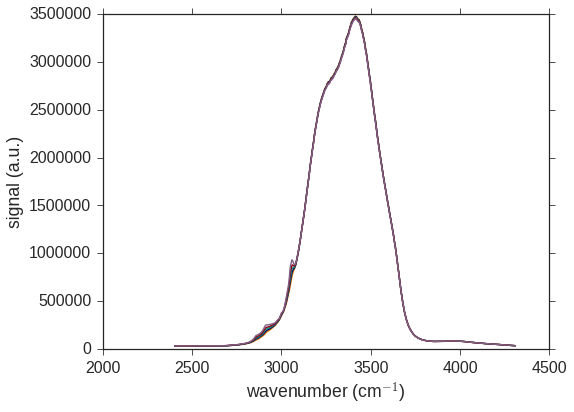

In [17]:
ratios = [0.001, 0.003, 0.005, 0.007, 0.01]
mixed_data = [i * carbon['signal'] + (1 - i) * water['signal'] for i in ratios]

mpl_spectrum()
for i in mixed_data:
    plt.plot(water['wavenumber'], i)
plt.show()

The basic 2-component NMF algorithm in question outputs two possible 'extreme' solutions for each of two components. I have called these extremes the 'near' extreme and the 'far' extreme of the 'high' and 'low' components. The final solution should be some linear combination of these two extremes, as given by:

$\vec{S}_1(\beta_1) = \beta_{1} \vec{A}_{1f} + (1 - \beta_1)\vec{A}_{1n} \quad 0 \leq \beta_1 \leq 1$

$\vec{S}_2(\beta_2) = \beta_{2} \vec{A}_{2f} + (1 - \beta_2)\vec{A}_{2n} \quad 0 \leq \beta_2 \leq 1$

Where $\vec{S}$ is the output, and $\vec{A}_{ij}$ are the four 'extreme' solutions. The default behaviour of the algorithm is to take the farthest extreme (labelled as 'high_far' or 'low_far' in the following plot, corresponding to $\beta=1$) as the best representation of the input data. Below are shown the extreme outputs of the algorithm.

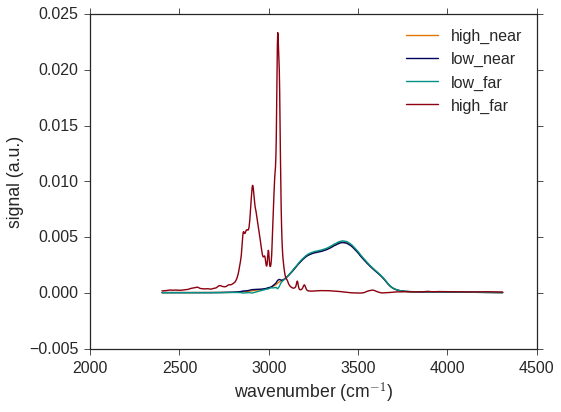

In [37]:
nu = water['wavenumber']
A, T, V = analytics.compute_hard_limits(mixed_data)

mpl_spectrum()
for key in A:
    plt.plot(nu, A[key], label=key)
plt.legend()
plt.show()

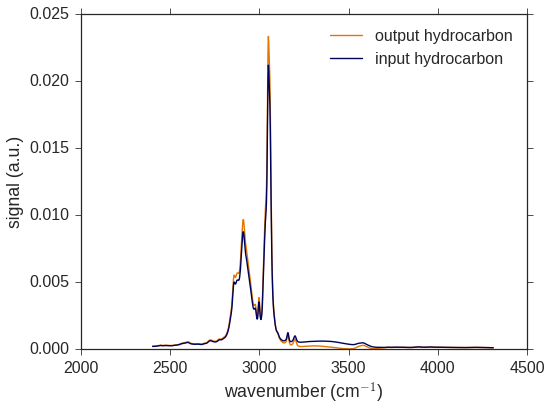

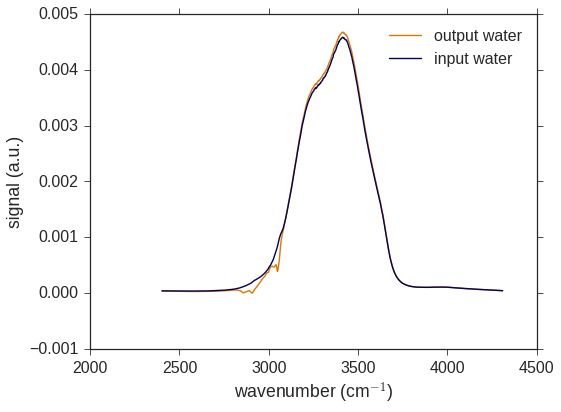

In [38]:
mpl_spectrum()
plt.plot(nu, A['high_far'], label='output hydrocarbon')
plt.plot(nu, carbon['signal'] / np.sum(carbon['signal']), label='input hydrocarbon')
plt.legend()
plt.show()

mpl_spectrum()
plt.plot(nu, A['low_far'], label='output water')
plt.plot(nu, water['signal'] / np.sum(water['signal']), label='input water')
plt.legend()
plt.show()

It looks as though even without added noise, this method will give us 'far' limits that are too far. This has to be because the assumption that the spectra share a wavenumber at which one signal is present but not the other, or vice versa, is incorrect. Let's put this true exploration on pause briefly to see what happens if we add a small amount of noise.

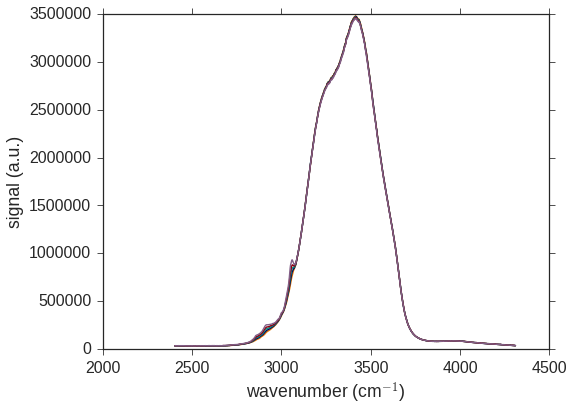

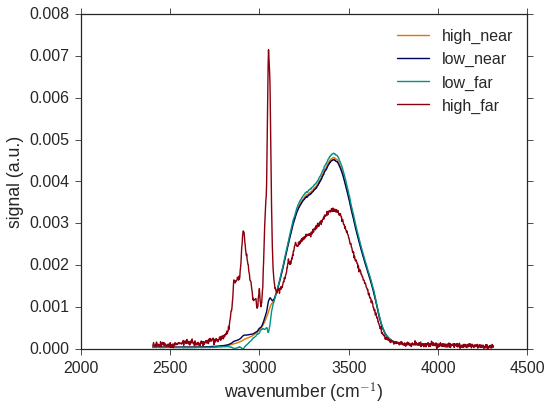

In [39]:
mpl_spectrum()
noisy_mixed_data = analytics.add_noise(mixed_data, 0.005)
for i in noisy_mixed_data:
    plt.plot(nu, i)
plt.show()

mpl_spectrum()
noiseA, noiseT, noiseV = analytics.compute_hard_limits(noisy_mixed_data)
for key in noiseA:
    plt.plot(nu, noiseA[key], label=key)
plt.legend()
plt.show()

When noise is added, the algorithm continues to predict an output for the water spectrum which is much too 'far'. However, the output for the hydrocarbon spectrum now contains significant contributions from the water spectrum, which are similar in appearance to those observed in recent papers. This is in spite of there being no cross-contribution from the spectrum itself.

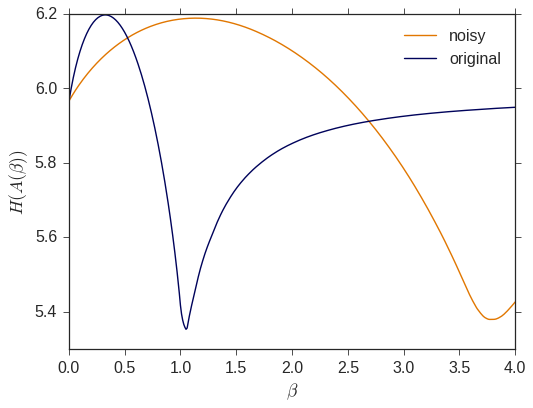

In [47]:
betavec = np.arange(0, 4.01, 0.01)
original_entropies = analytics.gridsearch_entropies(betavec, A, allpositive=True)
noisy_entropies = analytics.gridsearch_entropies(betavec, noiseA, allpositive=True)

plt.figure(figsize=(8, 6))
plt.plot(betavec, noisy_entropies, label='noisy')
plt.plot(betavec, original_entropies, label='original')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$H(S(\beta))$')
plt.legend()
plt.show()

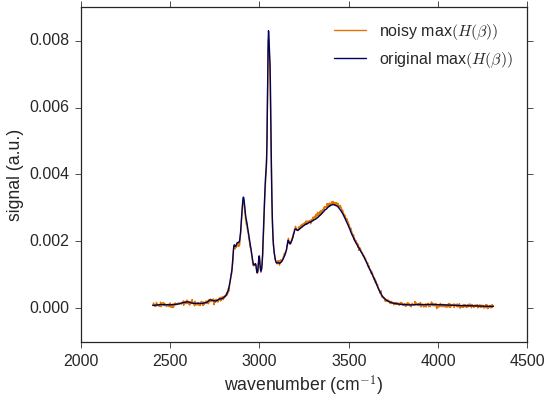

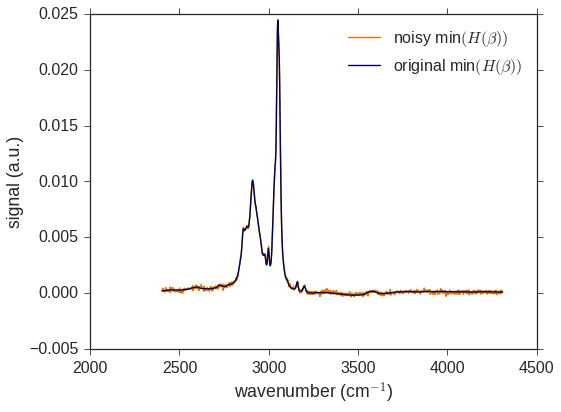

In [50]:
reload(analytics)
entmax_original = analytics.get_entmax(
    A, entropies=original_entropies, betavec=betavec
)
entmax_noisy= analytics.get_entmax(
    noiseA, entropies=noisy_entropies, betavec=betavec
)

mpl_spectrum()
plt.plot(nu, entmax_noisy, label=r'noisy max$(H(\beta))$')
plt.plot(nu, entmax_original, label=r'original max$(H(\beta))$')
plt.legend()
plt.show()

entmin_original = analytics.get_entmin(
    A, entropies=original_entropies, betavec=betavec
)
entmin_noisy= analytics.get_entmin(
    noiseA, entropies=noisy_entropies, betavec=betavec
)

mpl_spectrum()
plt.plot(nu, entmin_noisy, label=r'noisy min$(H(\beta))$')
plt.plot(nu, entmin_original, label=r'original min$(H(\beta))$')
plt.legend()
plt.show()

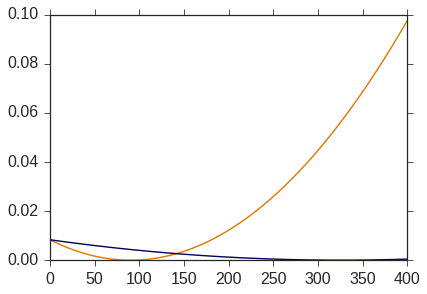

In [67]:
normS = carbon['signal'] / np.sum(carbon['signal'])
cstar_original = analytics.get_Cstar_matrix(A, betavec)
cstar_noisy = analytics.get_Cstar_matrix(noiseA, betavec)
ocosts = []
ncosts = []
for i in cstar_original:
    ocosts.append(np.sum((normS - i)**2))
for i in cstar_noisy:
    ncosts.append(np.sum((normS - i)**2))
plt.plot(ocosts)
plt.plot(ncosts)
plt.show()

obeta_true = betavec[np.argmin(np.asarray(ocosts))]
nbeta_true = betavec[np.argmin(np.asarray(ncosts))]

One possibility as to why is that the assumption that lets us take this approach - namely that the answers can be reconstructed by the two highest ranked eigenvectors with minimal error, which is gaussian, is false. Lets check to see if this is the case.

In [9]:
orig_R = np.transpose(np.asmatrix(mixed_data)) * np.asmatrix(mixed_data)
noisy_R = np.transpose(np.asmatrix(noisy_mixed_data)) * np.asmatrix(noisy_mixed_data)

orig_val, orig_vec = np.linalg.eigh(orig_R)
noisy_val, noisy_vec = np.linalg.eigh(noisy_R)

ov1, ov2 = np.asarray(np.transpose(orig_vec))[-1], np.asarray(np.transpose(orig_vec))[-2]
nv1, nv2 = np.asarray(np.transpose(noisy_vec))[-1], np.asarray(np.transpose(noisy_vec))[-2]

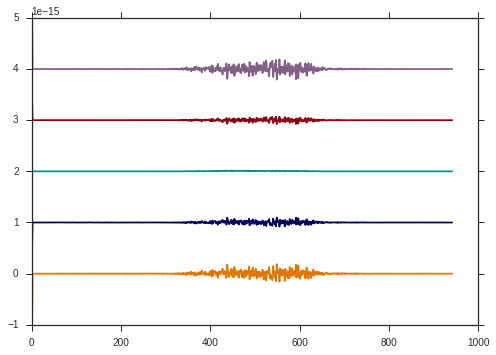

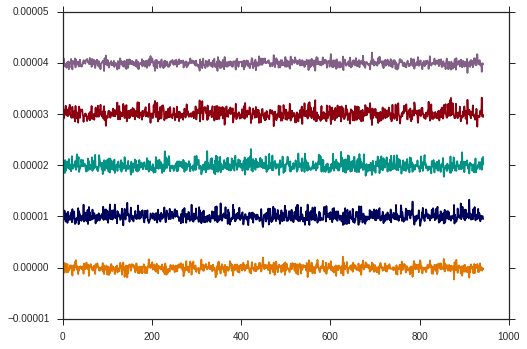

In [10]:
original_reconstructions = []
noisy_reconstructions = []
for i in range(len(mixed_data)):
    original_reconstructions.append(np.dot(ov1, mixed_data[i]) * ov1 + np.dot(ov2, mixed_data[i]) * ov2)
    noisy_reconstructions.append(np.dot(nv1, noisy_mixed_data[i]) * nv1 + np.dot(nv2, noisy_mixed_data[i]) * nv2)

orig_deviations = np.asarray([mixed_data[i] - original_reconstructions[i] for i in range(len(mixed_data))])
noisy_deviations = np.asarray([noisy_mixed_data[i] - noisy_reconstructions[i] for i in range(len(mixed_data))])

for i in range(len(orig_deviations)):
    plt.plot(orig_deviations[i] + i * 10e-16)
plt.show()

for i in range(len(noisy_deviations)):
    plt.plot(noisy_deviations[i] + i * 10e-6)
plt.show()

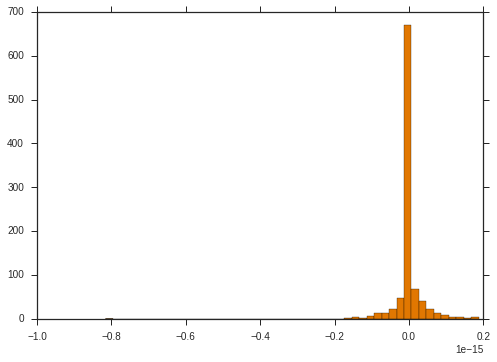

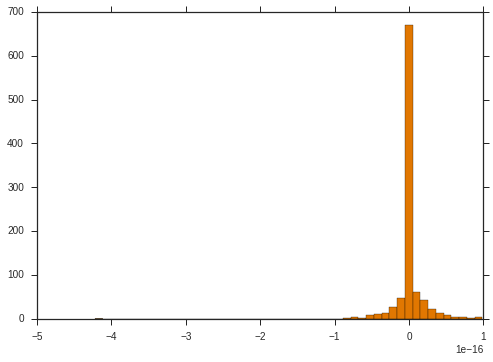

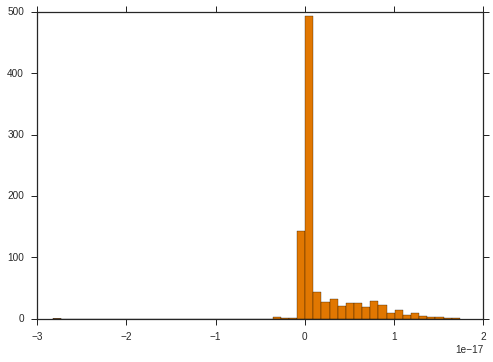

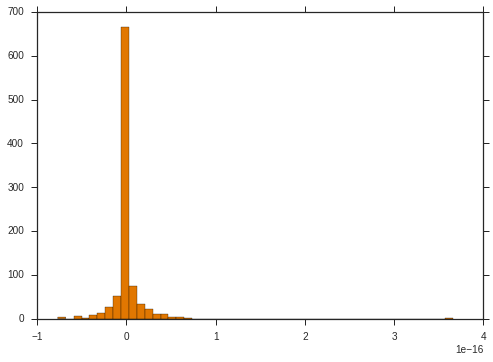

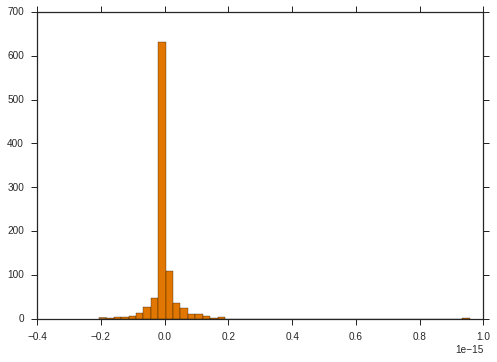

In [11]:
for i in orig_deviations:
    plt.hist(i, bins=50)
    plt.show()

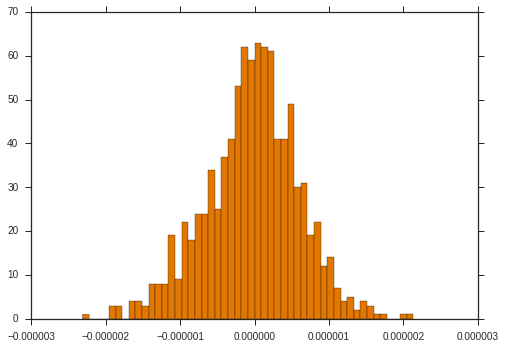

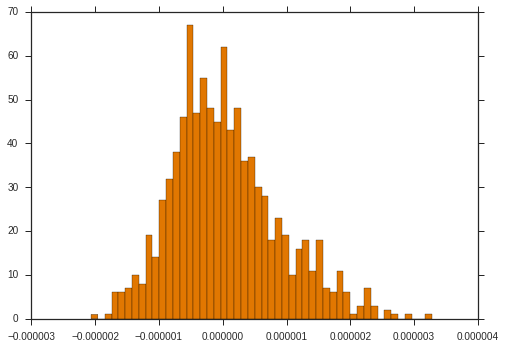

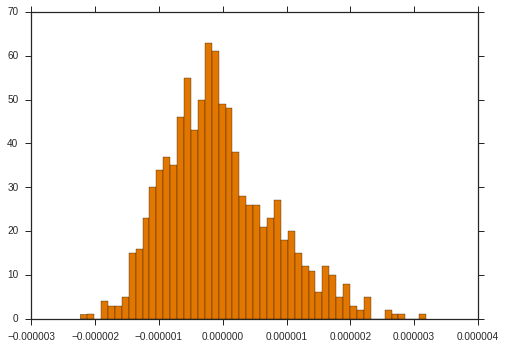

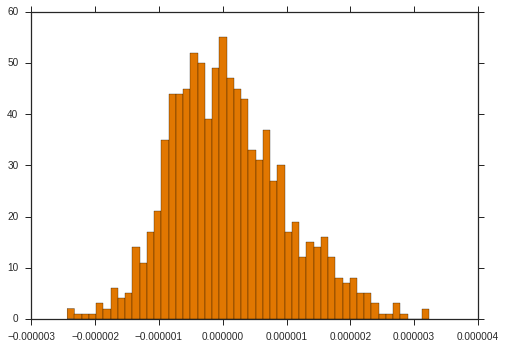

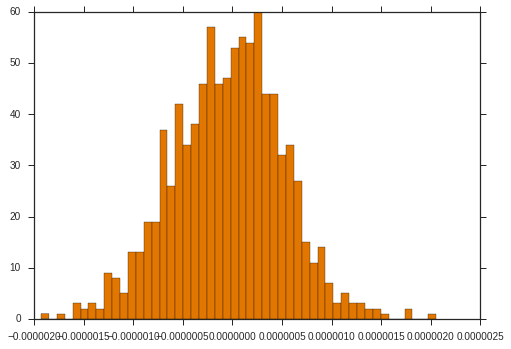

In [12]:
for i in noisy_deviations:
    plt.hist(i, bins=50)
    plt.show()

Neither the original deviations, nor the noise-added deviations appear truly gaussian, althought those with gaussian noise added appear to be more guassian. See the other document for an example of real residuals.

In fact, the residuals appear to be super-gaussian, implying a positive kurtosis. We can verify this quite easily.

In [17]:
import scipy.stats as sps
print 'Original:'
for i in orig_deviations:
    print 'Kurtosis = {}'.format(sps.kurtosis(i))

print '\nNoise Added:'
for i in noisy_deviations:
    print 'Kurtosis = {}'.format(sps.kurtosis(i))

Original:
Kurtosis = 162.806527114
Kurtosis = 157.734158005
Kurtosis = 7.82632205011
Kurtosis = 176.657527719
Kurtosis = 171.518371711

Noise Added:
Kurtosis = 0.384060112874
Kurtosis = 0.326196569831
Kurtosis = 0.23166611773
Kurtosis = 0.18298630021
Kurtosis = 0.236508234331
